In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e7dbe9ff3c2d5c4adbd2bb7ae04271823cfbacb83e4f56e83176cdf0cecdc9e9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as T
from torchinfo import summary

from efficientnet_pytorch import EfficientNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import random
from datetime import datetime
import pytz
import copy
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from PIL import Image
import cv2

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

print("Imports done!")

Imports done!


In [17]:
CONFIG = {
    "batchsize": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "epochs": 100
}

In [18]:
# # use this when not using a pretrained model
# transform = T.Compose([
#     T.ToTensor(),
#     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# use this when using a pretrained model (like Efficient)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_dataset = torchvision.datasets.CIFAR10(root="./data/", train=True, 
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data/", train=False, 
                                            download=True, transform=transform)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# train_loader = DataLoader(train_dataset, batch_size=CONFIG["batchsize"], shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=CONFIG["batchsize"], shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 29539539.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [19]:
# def fn():
#     X_train, X_valid, y_train, y_valid = train_test_split(train_dataset.data, train_dataset.targets, 
#                                                           test_size=0.2, random_state=42, shuffle=True, 
#                                                           stratify=train_dataset.targets)
#     y_train, y_valid = np.array(y_train), np.array(y_valid)
#     print(np.unique(y_train, return_counts=True), np.unique(y_valid, return_counts=True), sep='\n')
#     X_train = torch.tensor(X_train, dtype=torch.float64)
#     X_valid = torch.tensor(X_valid, dtype=torch.float64)
#     y_train = torch.tensor(y_train, dtype=torch.int64)
#     y_valid = torch.tensor(y_valid, dtype=torch.int64)
#     print(X_train.shape, y_train.shape)
#     print(X_valid.shape, y_valid.shape)
    
# fn()

In [20]:
len(train_dataset)

50000

In [21]:
len(train_dataset[0])

2

In [22]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [23]:
train_dataset[0][1]

6

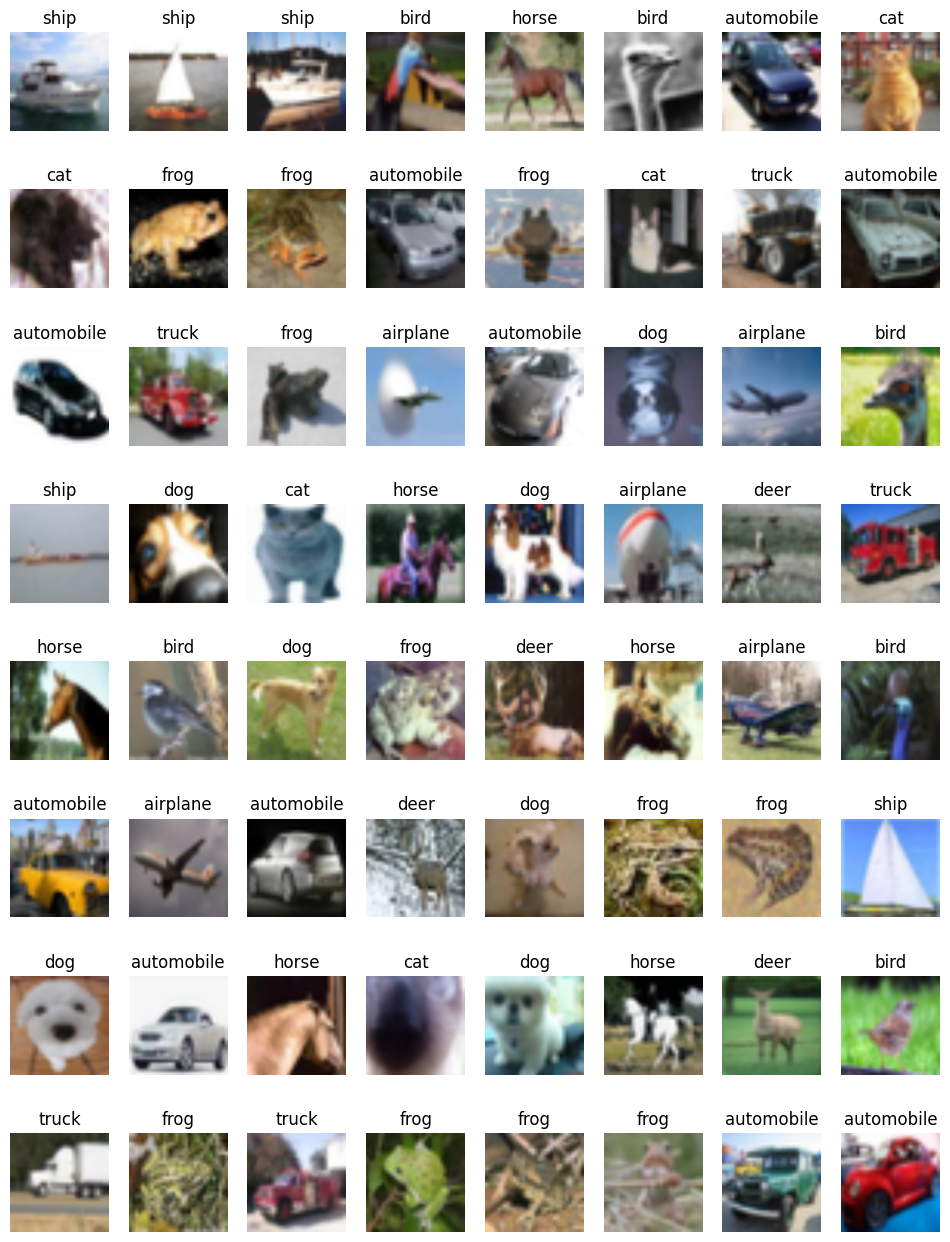

In [24]:
np.random.seed(CONFIG["seed"])

def visualize_data():
    nrows, ncols = 8, 8
    indices = np.random.randint(low=0, high=len(train_dataset), 
                                size=nrows*ncols).reshape(nrows, ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12,16))
    for i in range(nrows):
        for j in range(ncols):
            idx = indices[i][j]
            img = train_dataset[idx][0].permute(1,2,0)  # change from (C,H,W) to (H,W,C) 
            img = img/2 + 0.5  # unnormalize the image for visualization purpose
            label = train_dataset[idx][1]
            ax[i,j].imshow(img)
            ax[i,j].set_title(classes[label], fontsize=12)
            ax[i,j].axis("off")
    
    
visualize_data()

### Model

In [25]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)   # flatten all dimensios except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

Note: if the last layer of the model is `F.log_softmax(x)` then use the loss function `nn.NLLLoss`.

In [26]:
summary(model=Model1(), input_size=(1,3,32,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Model1 (Model1)                          [1, 3, 32, 32]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 3, 32, 32]       [1, 6, 28, 28]       456                  True
├─MaxPool2d (pool)                       [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Conv2d (conv2)                         [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
├─MaxPool2d (pool)                       [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Linear (fc1)                           [1, 400]             [1, 120]             48,120               True
├─Linear (fc2)                           [1, 120]             [1, 84]              10,164               True
├─Linear (fc3)                           [1, 84]              [1, 10]              850                  True
Total params: 62,0

In [49]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bnorm1 = nn.BatchNorm2d(num_features=64)
        self.bnorm2 = nn.BatchNorm2d(num_features=128)
        self.bnorm3 = nn.BatchNorm2d(num_features=256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bnorm1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.bnorm2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.bnorm3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [50]:
summary(model=Model2(), input_size=(1,3,32,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Model2 (Model2)                          [1, 3, 32, 32]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 3, 32, 32]       [1, 32, 32, 32]      896                  True
├─Conv2d (conv2)                         [1, 32, 32, 32]      [1, 64, 32, 32]      18,496               True
├─MaxPool2d (pool)                       [1, 64, 32, 32]      [1, 64, 16, 16]      --                   --
├─BatchNorm2d (bnorm1)                   [1, 64, 16, 16]      [1, 64, 16, 16]      128                  True
├─Conv2d (conv3)                         [1, 64, 16, 16]      [1, 128, 16, 16]     73,856               True
├─Conv2d (conv4)                         [1, 128, 16, 16]     [1, 128, 16, 16]     147,584              True
├─MaxPool2d (pool)                       [1, 128, 16, 16]     [1, 128, 8, 8]       --                   --
├─BatchNorm2d (bno

In [29]:
effnet_b2 = EfficientNet.from_pretrained("efficientnet-b2")
effnet_b2

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 71.0MB/s]

Loaded pretrained weights for efficientnet-b2


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [30]:
summary(model=effnet_b2, input_size=(1,3,32,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 32, 32]       [1, 1000]            --                   True
├─Conv2dStaticSamePadding (_conv_stem)                       [1, 3, 32, 32]       [1, 32, 16, 16]      864                  True
│    └─ZeroPad2d (static_padding)                            [1, 3, 32, 32]       [1, 3, 33, 33]       --                   --
├─BatchNorm2d (_bn0)                                         [1, 32, 16, 16]      [1, 32, 16, 16]      64                   True
├─MemoryEfficientSwish (_swish)                              [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   True
│    └─MBConvBlock (0)                                       [1, 32, 16, 16]      [1, 16, 16, 16

In [31]:
class Model3(nn.Module):
    def __init__(self, backbone_model):
        super(Model3, self).__init__()
        self.backbone = copy.deepcopy(backbone_model)
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    

In [32]:
summary(model=Model3(effnet_b2), input_size=(1,3,32,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Model3 (Model3)                                                   [1, 3, 32, 32]       [1, 10]              --                   Partial
├─EfficientNet (backbone)                                         [1, 3, 32, 32]       [1, 1000]            --                   False
│    └─Conv2dStaticSamePadding (_conv_stem)                       [1, 3, 32, 32]       [1, 32, 16, 16]      864                  False
│    │    └─ZeroPad2d (static_padding)                            [1, 3, 32, 32]       [1, 3, 33, 33]       --                   --
│    └─BatchNorm2d (_bn0)                                         [1, 32, 16, 16]      [1, 32, 16, 16]      (64)                 False
│    └─MemoryEfficientSwish (_swish)                              [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─ModuleList (_blocks)                            

In [47]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bnorm1 = nn.BatchNorm2d(num_features=64)
        self.bnorm2 = nn.BatchNorm2d(num_features=128)
        self.bnorm3 = nn.BatchNorm2d(num_features=256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = self.pool(x)
        x = self.bnorm1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.dropout1(x)
        x = self.pool(x)
        x = self.bnorm2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.dropout1(x)
        x = self.pool(x)
        x = self.bnorm3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [48]:
summary(model=Model4(), input_size=(1,3,32,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Model4 (Model4)                          [1, 3, 32, 32]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 3, 32, 32]       [1, 32, 32, 32]      896                  True
├─Conv2d (conv2)                         [1, 32, 32, 32]      [1, 64, 32, 32]      18,496               True
├─Dropout (dropout1)                     [1, 64, 32, 32]      [1, 64, 32, 32]      --                   --
├─MaxPool2d (pool)                       [1, 64, 32, 32]      [1, 64, 16, 16]      --                   --
├─BatchNorm2d (bnorm1)                   [1, 64, 16, 16]      [1, 64, 16, 16]      128                  True
├─Conv2d (conv3)                         [1, 64, 16, 16]      [1, 128, 16, 16]     73,856               True
├─Conv2d (conv4)                         [1, 128, 16, 16]     [1, 128, 16, 16]     147,584              True
├─Dropout (dropout

In [33]:
class CustomDataset(Dataset):
    def __init__(self, features, targets, augmentations=None):
        self.features = features
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        image = self.features[idx, :]
        image = torch.tensor(image, dtype=torch.float32)
        label = self.targets[idx]
        label = torch.tensor(label, dtype=torch.long)
        if self.augmentations is not None:
            image = self.augmentations(image)
        return image, label
        

In [34]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        if get_torch_version() <= 1.7:
            torch.set_deterministic(True)
        else:
            torch.use_deterministic_algorithms(True)
    

def compute_accuracy(y_pred, y):
    assert len(y_pred)==len(y), "length of y_pred and y must be equal"
    acc = torch.eq(y_pred, y).sum().item()
    acc = acc/len(y_pred)
    return acc


def train_validation_split(train_dataset):
    X_train, X_valid, y_train, y_valid = train_test_split(train_dataset.data, train_dataset.targets, 
                                                          test_size=0.2, random_state=42, shuffle=True, 
                                                          stratify=train_dataset.targets)
    X_train = torch.tensor(X_train, dtype=torch.float64).permute(0, 3, 1, 2)
    X_valid = torch.tensor(X_valid, dtype=torch.float64).permute(0, 3, 1, 2)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)
    return X_train, X_valid, y_train, y_valid
    

def predict(model, img_path, device):
    img = cv2.imread(img_path)
    if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    img2 = img.copy()
    img = torch.tensor(img)
    img = img.permute(1,2,0)
    img = img.unsqueeze(dim=0)
    img = img.to(device)
    model.eval()
    with torch.inference_mode():
        logit = model(img)
    pred_prob = torch.softmax(logit, dim=1)
    pred_label = pred_prob.argmax(dim=1)
    plt.imshow(img2)
    plt.axis("off")
    plt.label(f"Prediction: {classes[pred_label]}\t\tProbability: {round(pred_prob)}")
    plt.show()


def set_scheduler(scheduler, results, scheduler_on):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "val_acc":
        scheduler.step(results["val_acc"][-1])
    elif scheduler_on == "val_loss":
        scheduler.step(results["val_loss"][-1])
    elif scheduler_on == "train_acc":
        scheduler.step(results["train_acc"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def visualize_results(results):
    """Plot the training and validation loss and accuracy, given the results dictionary"""
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["valid_loss"], results["valid_acc"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    # ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].plot(x, train_loss, label="train_loss", color="orange")
    ax[0].plot(x, val_loss, label="valid_loss", color="blue")
    ax[0].legend()
    # ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(x, train_acc, label="train_acc", color="orange")
    ax[1].plot(x, val_acc, label="valid_acc", color="blue")
    ax[1].legend()
    plt.show()
    

def train_step(model, loss_fn, optimizer, dataloader, device):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logit = model(X)
        pred_prob = torch.softmax(logit, dim=1)
        pred_label = pred_prob.argmax(dim=1)
        # note: first put logit and then y in the loss_fn
        # otherwise, if you put y first and then logit, then it will raise an error
        loss = loss_fn(logit, y)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        acc = compute_accuracy(pred_label, y)
        train_acc += acc
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
        

def valid_step(model, loss_fn, dataloader, device):
    model.eval()
    valid_loss = 0
    valid_acc = 0
    model.eval()
    with torch.inference_mode():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logit = model(X)
            pred_prob = torch.softmax(logit, dim=1)
            pred_label = pred_prob.argmax(dim=1)
            # note: first put logit and then y in the loss_fn
            # otherwise, if you put y first and then logit, then it will raise an error
            loss = loss_fn(logit, y)
            valid_loss += loss.item()
            acc = compute_accuracy(pred_label, y)
            valid_acc += acc
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)
    return valid_loss, valid_acc


def training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                 epochs, scheduler=None, scheduler_on="val_acc", verbose=False):
    """
    Does model training and validation for one fold in a k-fold cross validation setting.
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, loss_fn, optimizer, train_dataloader, device)
        valid_loss, valid_acc = valid_step(model, loss_fn, valid_dataloader, device)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        if verbose: 
            print(
                    f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
                    f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                    f"Val_acc: {valid_acc:.5f}"
                )
        if scheduler is not None:
            scheduler = set_scheduler(scheduler, results, scheduler_on)
    visualize_results(results)


def training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, 
                 scheduler=None, scheduler_on="val_acc", verbose=False, n_splits=5):
    """
    Does the training and validation for all the folds in a k-fold cross validation setting.
    """
    kf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    MODELS = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X=train_dataset.data, y=train_dataset.targets)):
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(train_idx))
        valid_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(val_idx))
        results = training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                                epochs, scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
        train_loss = np.mean(results["train_loss"])
        valid_loss = np.mean(results["valid_loss"])
        train_acc = np.mean(results["train_acc"])
        valid_acc = np.mean(results["valid_acc"])
        print(
                f"Fold: {fold+1} | Train_loss: {train_loss:.5f} | "
                f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                f"Val_acc: {valid_acc:.5f}"
            )
        visualize_results(results)
        MODELS.append(model)
    return MODELS


def training_function(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=None, 
                      scheduler_on="val_acc", verbose=False, validation_strategy="train test split",
                      n_splits=5):
    """
    validation_strategy: choose either "train test split" or "k-fold cross validation"
    """
    if validation_strategy == "train test split":
        X_train, X_valid, y_train, y_valid = train_validation_split(train_dataset)
        train_dataset = CustomDataset(features=X_train, targets=y_train)
        valid_dataset = CustomDataset(features=X_valid, targets=y_valid)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=CONFIG["batchsize"], shuffle=True)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=CONFIG["batchsize"], shuffle=False)
        training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, epochs, 
                     scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
    elif validation_strategy == "k-fold cross validation":
        training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=scheduler, 
                     scheduler_on=scheduler_on, verbose=verbose, n_splits=n_splits)
    else:
        raise ValueError("Invalid validation strategy.\nChoose either \"train test split\" \
        or \"k-fold cross validation\"")

    

def save_model_info(path: str, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(os.path.join(path,model_name)))
    model.to(device)
    optimizer.load_state_dict(torch.load(os.path.join(path,optimizer_name)))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(os.path.join(path,scheduler_name)))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


print("Utility functions created!")

Utility functions created!


In [35]:
# # This function shows what happens when we use simple KFold vs. StratifiedKFold 

# def fn():
#     kf1 = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     kf2 = KFold(n_splits=5, shuffle=True, random_state=42)
#     for fold, (train_idx, val_idx) in enumerate(kf1.split(X=train_dataset.data, y=train_dataset.targets)):
#         print(f"Fold: {fold}")
#         print("valid indices:", len(val_idx), "\t\texample: ", val_idx[-1])
#         print("train indices:", len(train_idx), "\t\texample: ", train_idx[-1])
#         tgt = []
#         for idx in val_idx:
#             tgt.append(train_dataset.targets[idx])
#         tgt_arr = np.array(tgt)
#         print(np.unique(tgt_arr, return_counts=True))
#     print("\n\n")
#     for fold, (train_idx, val_idx) in enumerate(kf2.split(train_dataset)):
#         print(f"Fold: {fold}")
#         print("valid indices:", len(val_idx), "\t\texample: ", val_idx[-1])
#         print("train indices:", len(train_idx), "\t\texample: ", train_idx[-1])
#         tgt = []
#         for idx in val_idx:
#             tgt.append(train_dataset.targets[idx])
#         tgt_arr = np.array(tgt)
#         print(np.unique(tgt_arr, return_counts=True))
        
# fn()

In [36]:
# def fn():
#     kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     for fold, (train_idx, val_idx) in enumerate(kf.split(X=train_dataset.data, y=train_dataset.targets)):
#         trainloader = DataLoader(dataset=train_dataset, batch_size=64, sampler=SubsetRandomSampler(train_idx))
#         validloader = DataLoader(dataset=train_dataset, batch_size=64, sampler=SubsetRandomSampler(val_idx))
#         for X,y in trainloader:
#             print(X.shape)
#             print(y.shape)
#             break
#         for X,y in validloader:
#             print(X.shape)
#             print(y.shape)
#             break
#         return
    
# fn()
        

In [37]:
# def fn():
#     img = train_dataset.data[0]
#     lbl = train_dataset.targets[0]
#     print(img.shape)
#     plt.imshow(img)
#     plt.title(classes[lbl])
    
# fn()

In [38]:
# def fn():
#     # return torch.tensor(train_dataset[0][1], dtype=torch.int64)
#     trainloader = DataLoader(dataset=train_dataset, batch_size=64)
#     for X,y in trainloader:
#         X = X.to(device)
#         y = y.to(device)
#         logit = model1(X)
#         loss = nn.CrossEntropyLoss()(logit, y)
#         return loss
    

# fn()

In [42]:
CONFIG = {
    "batchsize": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "epochs": 10
}

In [27]:
device = CONFIG["device"]
epochs = CONFIG["epochs"]
model1 = Model1().to(device)
loss_fn = nn.CrossEntropyLoss()
# learning rate equal to 3e-4 is called the Karpathy constant, inspired from one of Andrej Karpathy's tweets
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=0.0005)
# scheduler = ...  # TODO
# MODELS = training_function(model1, loss_fn, optimizer, train_dataset, device, epochs,
#                            verbose=True, validation_strategy='k-fold cross validation')
training_function(model1, loss_fn, optimizer, train_dataset, device, epochs, verbose=True, 
                  validation_strategy='train test split')

  1%|          | 1/100 [00:03<05:56,  3.60s/it]

Epoch: 1 | Train_loss: 1.70593 | Train_acc: 0.37998 | Val_loss: 1.48439 | Val_acc: 0.46477


  2%|▏         | 2/100 [00:07<05:49,  3.56s/it]

Epoch: 2 | Train_loss: 1.44687 | Train_acc: 0.48185 | Val_loss: 1.44126 | Val_acc: 0.48129


  3%|▎         | 3/100 [00:10<05:44,  3.55s/it]

Epoch: 3 | Train_loss: 1.33227 | Train_acc: 0.52672 | Val_loss: 1.34840 | Val_acc: 0.52767


  4%|▍         | 4/100 [00:14<05:36,  3.51s/it]

Epoch: 4 | Train_loss: 1.23959 | Train_acc: 0.56060 | Val_loss: 1.33710 | Val_acc: 0.53593


  5%|▌         | 5/100 [00:17<05:32,  3.50s/it]

Epoch: 5 | Train_loss: 1.17580 | Train_acc: 0.58485 | Val_loss: 1.24588 | Val_acc: 0.56638


  6%|▌         | 6/100 [00:21<05:28,  3.50s/it]

Epoch: 6 | Train_loss: 1.11867 | Train_acc: 0.60615 | Val_loss: 1.22189 | Val_acc: 0.57494


  7%|▋         | 7/100 [00:24<05:23,  3.48s/it]

Epoch: 7 | Train_loss: 1.05951 | Train_acc: 0.62667 | Val_loss: 1.28058 | Val_acc: 0.56857


  8%|▊         | 8/100 [00:28<05:19,  3.47s/it]

Epoch: 8 | Train_loss: 1.01627 | Train_acc: 0.64295 | Val_loss: 1.26001 | Val_acc: 0.58041


  9%|▉         | 9/100 [00:31<05:16,  3.47s/it]

Epoch: 9 | Train_loss: 0.98603 | Train_acc: 0.64938 | Val_loss: 1.27505 | Val_acc: 0.56877


 10%|█         | 10/100 [00:34<05:13,  3.48s/it]

Epoch: 10 | Train_loss: 0.94923 | Train_acc: 0.66338 | Val_loss: 1.31751 | Val_acc: 0.56260


 11%|█         | 11/100 [00:38<05:10,  3.49s/it]

Epoch: 11 | Train_loss: 0.91499 | Train_acc: 0.67773 | Val_loss: 1.28652 | Val_acc: 0.57554


 12%|█▏        | 12/100 [00:42<05:07,  3.50s/it]

Epoch: 12 | Train_loss: 0.87732 | Train_acc: 0.68875 | Val_loss: 1.35432 | Val_acc: 0.56797


 13%|█▎        | 13/100 [00:45<05:04,  3.50s/it]

Epoch: 13 | Train_loss: 0.84391 | Train_acc: 0.70110 | Val_loss: 1.33413 | Val_acc: 0.56608


 14%|█▍        | 14/100 [00:48<04:59,  3.48s/it]

Epoch: 14 | Train_loss: 0.82813 | Train_acc: 0.70747 | Val_loss: 1.47232 | Val_acc: 0.55255


 15%|█▌        | 15/100 [00:52<04:53,  3.46s/it]

Epoch: 15 | Train_loss: 0.79754 | Train_acc: 0.71725 | Val_loss: 1.38912 | Val_acc: 0.57842


 16%|█▌        | 16/100 [00:55<04:50,  3.46s/it]

Epoch: 16 | Train_loss: 0.76413 | Train_acc: 0.72872 | Val_loss: 1.41021 | Val_acc: 0.57315


 17%|█▋        | 17/100 [00:59<04:48,  3.47s/it]

Epoch: 17 | Train_loss: 0.75351 | Train_acc: 0.73280 | Val_loss: 1.52132 | Val_acc: 0.54717


 18%|█▊        | 18/100 [01:02<04:43,  3.46s/it]

Epoch: 18 | Train_loss: 0.73580 | Train_acc: 0.73842 | Val_loss: 1.47739 | Val_acc: 0.56061


 19%|█▉        | 19/100 [01:06<04:40,  3.46s/it]

Epoch: 19 | Train_loss: 0.71368 | Train_acc: 0.74485 | Val_loss: 1.55347 | Val_acc: 0.56280


 20%|██        | 20/100 [01:09<04:37,  3.47s/it]

Epoch: 20 | Train_loss: 0.68497 | Train_acc: 0.75733 | Val_loss: 1.54384 | Val_acc: 0.56787


 21%|██        | 21/100 [01:13<04:32,  3.45s/it]

Epoch: 21 | Train_loss: 0.66593 | Train_acc: 0.76155 | Val_loss: 1.61510 | Val_acc: 0.54867


 22%|██▏       | 22/100 [01:16<04:32,  3.49s/it]

Epoch: 22 | Train_loss: 0.65461 | Train_acc: 0.76655 | Val_loss: 1.57883 | Val_acc: 0.56698


 23%|██▎       | 23/100 [01:20<04:27,  3.48s/it]

Epoch: 23 | Train_loss: 0.63304 | Train_acc: 0.77512 | Val_loss: 1.70034 | Val_acc: 0.56170


 24%|██▍       | 24/100 [01:23<04:22,  3.46s/it]

Epoch: 24 | Train_loss: 0.61449 | Train_acc: 0.78028 | Val_loss: 1.70890 | Val_acc: 0.55474


 25%|██▌       | 25/100 [01:27<04:19,  3.47s/it]

Epoch: 25 | Train_loss: 0.60717 | Train_acc: 0.78112 | Val_loss: 1.75245 | Val_acc: 0.56559


 26%|██▌       | 26/100 [01:30<04:14,  3.44s/it]

Epoch: 26 | Train_loss: 0.59400 | Train_acc: 0.78725 | Val_loss: 1.83057 | Val_acc: 0.55723


 27%|██▋       | 27/100 [01:33<04:10,  3.44s/it]

Epoch: 27 | Train_loss: 0.57398 | Train_acc: 0.79538 | Val_loss: 1.82063 | Val_acc: 0.56230


 28%|██▊       | 28/100 [01:37<04:07,  3.44s/it]

Epoch: 28 | Train_loss: 0.56646 | Train_acc: 0.79740 | Val_loss: 1.86198 | Val_acc: 0.55484


 29%|██▉       | 29/100 [01:40<04:04,  3.44s/it]

Epoch: 29 | Train_loss: 0.55177 | Train_acc: 0.80450 | Val_loss: 1.93804 | Val_acc: 0.54548


 30%|███       | 30/100 [01:44<04:00,  3.43s/it]

Epoch: 30 | Train_loss: 0.55355 | Train_acc: 0.80240 | Val_loss: 1.94484 | Val_acc: 0.54598


 31%|███       | 31/100 [01:47<03:58,  3.46s/it]

Epoch: 31 | Train_loss: 0.52233 | Train_acc: 0.81680 | Val_loss: 1.94377 | Val_acc: 0.54996


 32%|███▏      | 32/100 [01:51<03:54,  3.45s/it]

Epoch: 32 | Train_loss: 0.52260 | Train_acc: 0.81430 | Val_loss: 1.92153 | Val_acc: 0.55185


 33%|███▎      | 33/100 [01:54<03:51,  3.46s/it]

Epoch: 33 | Train_loss: 0.51123 | Train_acc: 0.81695 | Val_loss: 1.96662 | Val_acc: 0.55205


 34%|███▍      | 34/100 [01:57<03:47,  3.44s/it]

Epoch: 34 | Train_loss: 0.50363 | Train_acc: 0.81963 | Val_loss: 2.10655 | Val_acc: 0.54439


 35%|███▌      | 35/100 [02:01<03:43,  3.43s/it]

Epoch: 35 | Train_loss: 0.48769 | Train_acc: 0.82585 | Val_loss: 2.02735 | Val_acc: 0.54717


 36%|███▌      | 36/100 [02:04<03:39,  3.43s/it]

Epoch: 36 | Train_loss: 0.47093 | Train_acc: 0.83088 | Val_loss: 2.17987 | Val_acc: 0.55265


 37%|███▋      | 37/100 [02:08<03:36,  3.44s/it]

Epoch: 37 | Train_loss: 0.47635 | Train_acc: 0.83105 | Val_loss: 2.17017 | Val_acc: 0.55125


 38%|███▊      | 38/100 [02:11<03:33,  3.44s/it]

Epoch: 38 | Train_loss: 0.45627 | Train_acc: 0.84055 | Val_loss: 2.19305 | Val_acc: 0.53414


 39%|███▉      | 39/100 [02:15<03:29,  3.44s/it]

Epoch: 39 | Train_loss: 0.44392 | Train_acc: 0.84167 | Val_loss: 2.30802 | Val_acc: 0.54986


 40%|████      | 40/100 [02:18<03:28,  3.48s/it]

Epoch: 40 | Train_loss: 0.42982 | Train_acc: 0.84793 | Val_loss: 2.40625 | Val_acc: 0.54976


 41%|████      | 41/100 [02:22<03:24,  3.46s/it]

Epoch: 41 | Train_loss: 0.44076 | Train_acc: 0.84445 | Val_loss: 2.31074 | Val_acc: 0.54399


 42%|████▏     | 42/100 [02:25<03:20,  3.46s/it]

Epoch: 42 | Train_loss: 0.45745 | Train_acc: 0.83778 | Val_loss: 2.32276 | Val_acc: 0.54767


 43%|████▎     | 43/100 [02:29<03:16,  3.45s/it]

Epoch: 43 | Train_loss: 0.41637 | Train_acc: 0.85155 | Val_loss: 2.48055 | Val_acc: 0.54240


 44%|████▍     | 44/100 [02:32<03:12,  3.43s/it]

Epoch: 44 | Train_loss: 0.42176 | Train_acc: 0.85255 | Val_loss: 2.51504 | Val_acc: 0.54289


 45%|████▌     | 45/100 [02:35<03:09,  3.44s/it]

Epoch: 45 | Train_loss: 0.40989 | Train_acc: 0.85570 | Val_loss: 2.49582 | Val_acc: 0.53672


 46%|████▌     | 46/100 [02:39<03:05,  3.43s/it]

Epoch: 46 | Train_loss: 0.40971 | Train_acc: 0.85408 | Val_loss: 2.56005 | Val_acc: 0.54717


 47%|████▋     | 47/100 [02:42<03:01,  3.43s/it]

Epoch: 47 | Train_loss: 0.41211 | Train_acc: 0.85542 | Val_loss: 2.64349 | Val_acc: 0.52398


 48%|████▊     | 48/100 [02:46<02:58,  3.44s/it]

Epoch: 48 | Train_loss: 0.39604 | Train_acc: 0.86072 | Val_loss: 2.60523 | Val_acc: 0.54827


 49%|████▉     | 49/100 [02:49<02:57,  3.48s/it]

Epoch: 49 | Train_loss: 0.41227 | Train_acc: 0.85410 | Val_loss: 2.59648 | Val_acc: 0.53991


 50%|█████     | 50/100 [02:53<02:53,  3.48s/it]

Epoch: 50 | Train_loss: 0.38674 | Train_acc: 0.86235 | Val_loss: 2.76512 | Val_acc: 0.52797


 51%|█████     | 51/100 [02:56<02:50,  3.49s/it]

Epoch: 51 | Train_loss: 0.39097 | Train_acc: 0.86160 | Val_loss: 2.74559 | Val_acc: 0.54578


 52%|█████▏    | 52/100 [03:00<02:45,  3.46s/it]

Epoch: 52 | Train_loss: 0.39897 | Train_acc: 0.85875 | Val_loss: 2.67904 | Val_acc: 0.54230


 53%|█████▎    | 53/100 [03:03<02:41,  3.44s/it]

Epoch: 53 | Train_loss: 0.37664 | Train_acc: 0.86682 | Val_loss: 2.69312 | Val_acc: 0.54041


 54%|█████▍    | 54/100 [03:06<02:38,  3.45s/it]

Epoch: 54 | Train_loss: 0.39369 | Train_acc: 0.86138 | Val_loss: 2.83953 | Val_acc: 0.54190


 55%|█████▌    | 55/100 [03:10<02:34,  3.43s/it]

Epoch: 55 | Train_loss: 0.37159 | Train_acc: 0.86813 | Val_loss: 2.88852 | Val_acc: 0.53842


 56%|█████▌    | 56/100 [03:13<02:30,  3.43s/it]

Epoch: 56 | Train_loss: 0.38480 | Train_acc: 0.86557 | Val_loss: 2.78170 | Val_acc: 0.54200


 57%|█████▋    | 57/100 [03:17<02:27,  3.43s/it]

Epoch: 57 | Train_loss: 0.34703 | Train_acc: 0.87775 | Val_loss: 3.01627 | Val_acc: 0.54210


 58%|█████▊    | 58/100 [03:20<02:24,  3.44s/it]

Epoch: 58 | Train_loss: 0.36573 | Train_acc: 0.87235 | Val_loss: 2.90859 | Val_acc: 0.53643


 59%|█████▉    | 59/100 [03:24<02:21,  3.46s/it]

Epoch: 59 | Train_loss: 0.35622 | Train_acc: 0.87577 | Val_loss: 3.00074 | Val_acc: 0.53453


 60%|██████    | 60/100 [03:27<02:18,  3.46s/it]

Epoch: 60 | Train_loss: 0.34665 | Train_acc: 0.87835 | Val_loss: 3.06748 | Val_acc: 0.53364


 61%|██████    | 61/100 [03:31<02:14,  3.45s/it]

Epoch: 61 | Train_loss: 0.37485 | Train_acc: 0.87120 | Val_loss: 2.98701 | Val_acc: 0.53722


 62%|██████▏   | 62/100 [03:34<02:10,  3.43s/it]

Epoch: 62 | Train_loss: 0.36181 | Train_acc: 0.87362 | Val_loss: 3.05076 | Val_acc: 0.54061


 63%|██████▎   | 63/100 [03:37<02:07,  3.44s/it]

Epoch: 63 | Train_loss: 0.33292 | Train_acc: 0.88370 | Val_loss: 3.14654 | Val_acc: 0.53941


 64%|██████▍   | 64/100 [03:41<02:03,  3.43s/it]

Epoch: 64 | Train_loss: 0.35302 | Train_acc: 0.87660 | Val_loss: 3.14451 | Val_acc: 0.54319


 65%|██████▌   | 65/100 [03:44<01:59,  3.42s/it]

Epoch: 65 | Train_loss: 0.34326 | Train_acc: 0.88170 | Val_loss: 3.16482 | Val_acc: 0.53254


 66%|██████▌   | 66/100 [03:48<01:56,  3.42s/it]

Epoch: 66 | Train_loss: 0.35401 | Train_acc: 0.87703 | Val_loss: 3.15653 | Val_acc: 0.53553


 67%|██████▋   | 67/100 [03:51<01:52,  3.42s/it]

Epoch: 67 | Train_loss: 0.33969 | Train_acc: 0.88240 | Val_loss: 3.34587 | Val_acc: 0.53225


 68%|██████▊   | 68/100 [03:55<01:50,  3.44s/it]

Epoch: 68 | Train_loss: 0.35878 | Train_acc: 0.87590 | Val_loss: 3.28183 | Val_acc: 0.52807


 69%|██████▉   | 69/100 [03:58<01:46,  3.44s/it]

Epoch: 69 | Train_loss: 0.30240 | Train_acc: 0.89385 | Val_loss: 3.39770 | Val_acc: 0.53483


 70%|███████   | 70/100 [04:01<01:43,  3.44s/it]

Epoch: 70 | Train_loss: 0.34038 | Train_acc: 0.88190 | Val_loss: 3.28561 | Val_acc: 0.54001


 71%|███████   | 71/100 [04:05<01:39,  3.45s/it]

Epoch: 71 | Train_loss: 0.35673 | Train_acc: 0.88030 | Val_loss: 3.24366 | Val_acc: 0.52826


 72%|███████▏  | 72/100 [04:08<01:35,  3.43s/it]

Epoch: 72 | Train_loss: 0.33751 | Train_acc: 0.88467 | Val_loss: 3.25783 | Val_acc: 0.54260


 73%|███████▎  | 73/100 [04:12<01:32,  3.43s/it]

Epoch: 73 | Train_loss: 0.30922 | Train_acc: 0.89430 | Val_loss: 3.40741 | Val_acc: 0.52747


 74%|███████▍  | 74/100 [04:15<01:29,  3.44s/it]

Epoch: 74 | Train_loss: 0.32708 | Train_acc: 0.88715 | Val_loss: 3.39159 | Val_acc: 0.54279


 75%|███████▌  | 75/100 [04:19<01:25,  3.43s/it]

Epoch: 75 | Train_loss: 0.31301 | Train_acc: 0.89387 | Val_loss: 3.47425 | Val_acc: 0.53951


 76%|███████▌  | 76/100 [04:22<01:22,  3.43s/it]

Epoch: 76 | Train_loss: 0.32631 | Train_acc: 0.88858 | Val_loss: 3.53208 | Val_acc: 0.53085


 76%|███████▌  | 76/100 [04:23<01:23,  3.47s/it]


KeyboardInterrupt: 

**Note: training using k-fold cross-validation takes a lot of time. This is not worth it. Simple train test split will also work.**

  3%|▎         | 1/30 [00:08<04:06,  8.49s/it]

Epoch: 1 | Train_loss: 1.17068 | Train_acc: 0.57665 | Val_loss: 0.96136 | Val_acc: 0.65794


  7%|▋         | 2/30 [00:16<03:57,  8.48s/it]

Epoch: 2 | Train_loss: 0.80033 | Train_acc: 0.71905 | Val_loss: 0.77548 | Val_acc: 0.73567


 10%|█         | 3/30 [00:25<03:49,  8.50s/it]

Epoch: 3 | Train_loss: 0.66322 | Train_acc: 0.77263 | Val_loss: 0.68077 | Val_acc: 0.76473


 13%|█▎        | 4/30 [00:33<03:40,  8.49s/it]

Epoch: 4 | Train_loss: 0.58691 | Train_acc: 0.79902 | Val_loss: 0.62394 | Val_acc: 0.78424


 17%|█▋        | 5/30 [00:42<03:32,  8.49s/it]

Epoch: 5 | Train_loss: 0.52311 | Train_acc: 0.82303 | Val_loss: 0.60436 | Val_acc: 0.79827


 20%|██        | 6/30 [00:50<03:23,  8.49s/it]

Epoch: 6 | Train_loss: 0.47665 | Train_acc: 0.83745 | Val_loss: 0.55166 | Val_acc: 0.81190


 23%|██▎       | 7/30 [00:59<03:15,  8.50s/it]

Epoch: 7 | Train_loss: 0.43879 | Train_acc: 0.85305 | Val_loss: 0.63002 | Val_acc: 0.79090


 27%|██▋       | 8/30 [01:07<03:07,  8.50s/it]

Epoch: 8 | Train_loss: 0.40906 | Train_acc: 0.86257 | Val_loss: 0.55208 | Val_acc: 0.81379


 30%|███       | 9/30 [01:16<02:58,  8.50s/it]

Epoch: 9 | Train_loss: 0.37250 | Train_acc: 0.87633 | Val_loss: 0.52747 | Val_acc: 0.82265


 33%|███▎      | 10/30 [01:24<02:50,  8.51s/it]

Epoch: 10 | Train_loss: 0.35302 | Train_acc: 0.88208 | Val_loss: 0.53274 | Val_acc: 0.82156


 37%|███▋      | 11/30 [01:33<02:41,  8.52s/it]

Epoch: 11 | Train_loss: 0.33965 | Train_acc: 0.88838 | Val_loss: 0.51823 | Val_acc: 0.82474


 40%|████      | 12/30 [01:42<02:33,  8.51s/it]

Epoch: 12 | Train_loss: 0.32238 | Train_acc: 0.89392 | Val_loss: 0.58754 | Val_acc: 0.80713


 43%|████▎     | 13/30 [01:50<02:24,  8.51s/it]

Epoch: 13 | Train_loss: 0.29920 | Train_acc: 0.90228 | Val_loss: 0.50897 | Val_acc: 0.83171


 47%|████▋     | 14/30 [01:59<02:16,  8.51s/it]

Epoch: 14 | Train_loss: 0.28874 | Train_acc: 0.90400 | Val_loss: 0.51993 | Val_acc: 0.83071


 50%|█████     | 15/30 [02:07<02:07,  8.51s/it]

Epoch: 15 | Train_loss: 0.27654 | Train_acc: 0.90890 | Val_loss: 0.55105 | Val_acc: 0.81877


 53%|█████▎    | 16/30 [02:16<01:59,  8.50s/it]

Epoch: 16 | Train_loss: 0.26821 | Train_acc: 0.91343 | Val_loss: 0.49994 | Val_acc: 0.83350


 57%|█████▋    | 17/30 [02:24<01:50,  8.51s/it]

Epoch: 17 | Train_loss: 0.25534 | Train_acc: 0.91853 | Val_loss: 0.57019 | Val_acc: 0.81290


 60%|██████    | 18/30 [02:33<01:42,  8.51s/it]

Epoch: 18 | Train_loss: 0.25200 | Train_acc: 0.91848 | Val_loss: 0.57049 | Val_acc: 0.80872


 63%|██████▎   | 19/30 [02:41<01:33,  8.52s/it]

Epoch: 19 | Train_loss: 0.23637 | Train_acc: 0.92405 | Val_loss: 0.50498 | Val_acc: 0.83549


 67%|██████▋   | 20/30 [02:50<01:25,  8.51s/it]

Epoch: 20 | Train_loss: 0.23940 | Train_acc: 0.92225 | Val_loss: 0.54295 | Val_acc: 0.82504


 70%|███████   | 21/30 [02:58<01:16,  8.50s/it]

Epoch: 21 | Train_loss: 0.22670 | Train_acc: 0.92595 | Val_loss: 0.58907 | Val_acc: 0.81091


 73%|███████▎  | 22/30 [03:07<01:08,  8.52s/it]

Epoch: 22 | Train_loss: 0.22491 | Train_acc: 0.92748 | Val_loss: 0.55547 | Val_acc: 0.81618


 77%|███████▋  | 23/30 [03:15<00:59,  8.51s/it]

Epoch: 23 | Train_loss: 0.21597 | Train_acc: 0.93185 | Val_loss: 0.55319 | Val_acc: 0.81728


 80%|████████  | 24/30 [03:24<00:51,  8.51s/it]

Epoch: 24 | Train_loss: 0.21576 | Train_acc: 0.93135 | Val_loss: 0.49525 | Val_acc: 0.83907


 83%|████████▎ | 25/30 [03:32<00:42,  8.51s/it]

Epoch: 25 | Train_loss: 0.21495 | Train_acc: 0.93158 | Val_loss: 0.51611 | Val_acc: 0.83111


 87%|████████▋ | 26/30 [03:41<00:34,  8.51s/it]

Epoch: 26 | Train_loss: 0.21624 | Train_acc: 0.93040 | Val_loss: 0.64891 | Val_acc: 0.80046


 90%|█████████ | 27/30 [03:49<00:25,  8.50s/it]

Epoch: 27 | Train_loss: 0.20407 | Train_acc: 0.93478 | Val_loss: 0.52196 | Val_acc: 0.83211


 93%|█████████▎| 28/30 [03:58<00:16,  8.50s/it]

Epoch: 28 | Train_loss: 0.20517 | Train_acc: 0.93468 | Val_loss: 0.56216 | Val_acc: 0.81608


 97%|█████████▋| 29/30 [04:06<00:08,  8.50s/it]

Epoch: 29 | Train_loss: 0.20121 | Train_acc: 0.93642 | Val_loss: 0.52686 | Val_acc: 0.83101


100%|██████████| 30/30 [04:15<00:00,  8.51s/it]

Epoch: 30 | Train_loss: 0.20208 | Train_acc: 0.93678 | Val_loss: 0.51065 | Val_acc: 0.83509


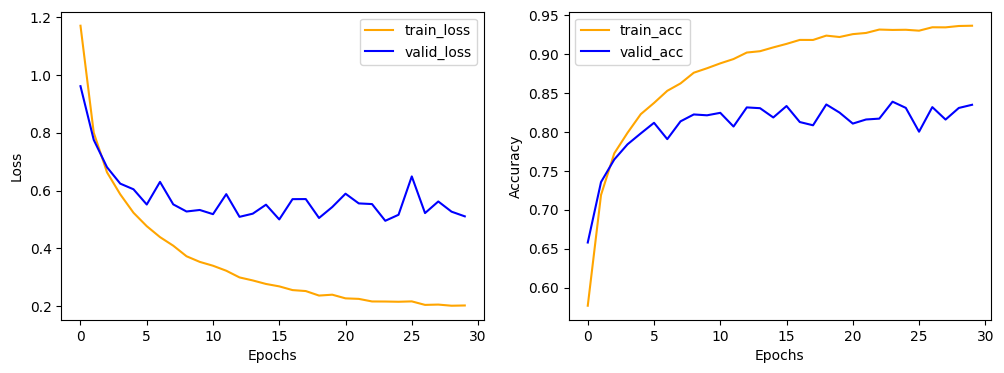

In [45]:
CONFIG = {
    "batchsize": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "epochs": 30
}

device = CONFIG["device"]
epochs = CONFIG["epochs"]
model2 = Model2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=4e-4, weight_decay=0.009)
# scheduler = ...  # TODO
training_function(model2, loss_fn, optimizer, train_dataset, device, epochs, verbose=True, 
                  validation_strategy='train test split')

In [46]:
curr_time = get_current_time()
curr_time

'29_08_2024__18_29_34'

In [55]:
path = os.path.join(os.getcwd(), curr_time)
os.makedirs(path, exist_ok=True)

print(path)

/kaggle/working/29_08_2024__18_29_34


In [50]:
model_name = "Model2_1.pt"
optimizer_name = "Adam_1.pt"

save_model_info(path, device, model2, model_name, optimizer, optimizer_name)

Model info saved!


In [56]:
path = "/kaggle/working/29_08_2024__18_29_34"
loaded_model1 = Model2().to(device)
loaded_optimizer1 = optim.Adam(params=loaded_model1.parameters(), lr=3e-4, weight_decay=0.005)
load_model_info(path, device, loaded_model1, model_name, loaded_optimizer1, optimizer_name)

Model info loaded!


In [ ]:
effnet_b2 = EfficientNet.from_pretrained("efficientnet-b2")

In [43]:
CONFIG = {
    "batchsize": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "epochs": 11
}

device = CONFIG["device"]
epochs = CONFIG["epochs"]
model3 = Model3(effnet_b2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001, weight_decay=0.0005)
# scheduler = ...  # TODO
training_function(model3, loss_fn, optimizer, train_dataset, device, epochs, verbose=True, 
                  validation_strategy='train test split')

  9%|▉         | 1/11 [00:19<03:19, 19.90s/it]

Epoch: 1 | Train_loss: 2.08792 | Train_acc: 0.24802 | Val_loss: 1.98001 | Val_acc: 0.30941


 18%|█▊        | 2/11 [00:39<02:59, 19.92s/it]

Epoch: 2 | Train_loss: 2.01772 | Train_acc: 0.27737 | Val_loss: 1.94868 | Val_acc: 0.31340


 27%|██▋       | 3/11 [00:59<02:38, 19.80s/it]

Epoch: 3 | Train_loss: 2.00613 | Train_acc: 0.28475 | Val_loss: 1.94768 | Val_acc: 0.31797


 36%|███▋      | 4/11 [01:19<02:18, 19.81s/it]

Epoch: 4 | Train_loss: 2.00033 | Train_acc: 0.28645 | Val_loss: 1.93041 | Val_acc: 0.31937


 45%|████▌     | 5/11 [01:39<01:58, 19.82s/it]

Epoch: 5 | Train_loss: 1.99036 | Train_acc: 0.28995 | Val_loss: 1.92635 | Val_acc: 0.32832


 45%|████▌     | 5/11 [01:52<02:15, 22.50s/it]


KeyboardInterrupt: 

  2%|▏         | 1/45 [00:08<06:23,  8.71s/it]

Epoch: 1 | Train_loss: 1.24274 | Train_acc: 0.55168 | Val_loss: 1.81011 | Val_acc: 0.37908


  4%|▍         | 2/45 [00:17<06:14,  8.70s/it]

Epoch: 2 | Train_loss: 0.87688 | Train_acc: 0.69142 | Val_loss: 1.39442 | Val_acc: 0.50368


  7%|▋         | 3/45 [00:26<06:05,  8.70s/it]

Epoch: 3 | Train_loss: 0.75876 | Train_acc: 0.73552 | Val_loss: 1.49891 | Val_acc: 0.46357


  9%|▉         | 4/45 [00:34<05:56,  8.70s/it]

Epoch: 4 | Train_loss: 0.68554 | Train_acc: 0.76562 | Val_loss: 0.96365 | Val_acc: 0.66212


 11%|█         | 5/45 [00:43<05:48,  8.70s/it]

Epoch: 5 | Train_loss: 0.62875 | Train_acc: 0.78500 | Val_loss: 0.96911 | Val_acc: 0.65535


 13%|█▎        | 6/45 [00:52<05:39,  8.70s/it]

Epoch: 6 | Train_loss: 0.58689 | Train_acc: 0.80183 | Val_loss: 0.94665 | Val_acc: 0.67377


 16%|█▌        | 7/45 [01:00<05:30,  8.71s/it]

Epoch: 7 | Train_loss: 0.55389 | Train_acc: 0.81302 | Val_loss: 0.77744 | Val_acc: 0.73408


 18%|█▊        | 8/45 [01:09<05:22,  8.71s/it]

Epoch: 8 | Train_loss: 0.52441 | Train_acc: 0.82475 | Val_loss: 0.78766 | Val_acc: 0.73796


 20%|██        | 9/45 [01:18<05:13,  8.71s/it]

Epoch: 9 | Train_loss: 0.50218 | Train_acc: 0.83217 | Val_loss: 0.68616 | Val_acc: 0.78045


 22%|██▏       | 10/45 [01:27<05:05,  8.72s/it]

Epoch: 10 | Train_loss: 0.47654 | Train_acc: 0.84088 | Val_loss: 0.95111 | Val_acc: 0.65983


 24%|██▍       | 11/45 [01:35<04:56,  8.72s/it]

Epoch: 11 | Train_loss: 0.47386 | Train_acc: 0.84195 | Val_loss: 0.71245 | Val_acc: 0.76592


 27%|██▋       | 12/45 [01:44<04:48,  8.73s/it]

Epoch: 12 | Train_loss: 0.45729 | Train_acc: 0.84675 | Val_loss: 0.73425 | Val_acc: 0.76184


 29%|██▉       | 13/45 [01:53<04:39,  8.73s/it]

Epoch: 13 | Train_loss: 0.44711 | Train_acc: 0.85218 | Val_loss: 0.65224 | Val_acc: 0.79289


 31%|███       | 14/45 [02:02<04:32,  8.79s/it]

Epoch: 14 | Train_loss: 0.43441 | Train_acc: 0.85650 | Val_loss: 0.61165 | Val_acc: 0.81330


 33%|███▎      | 15/45 [02:11<04:23,  8.78s/it]

Epoch: 15 | Train_loss: 0.42606 | Train_acc: 0.85765 | Val_loss: 0.65483 | Val_acc: 0.79299


 36%|███▌      | 16/45 [02:19<04:14,  8.77s/it]

Epoch: 16 | Train_loss: 0.41538 | Train_acc: 0.86410 | Val_loss: 0.72720 | Val_acc: 0.76025


 38%|███▊      | 17/45 [02:28<04:05,  8.76s/it]

Epoch: 17 | Train_loss: 0.40487 | Train_acc: 0.86725 | Val_loss: 0.66087 | Val_acc: 0.80076


 40%|████      | 18/45 [02:37<03:56,  8.75s/it]

Epoch: 18 | Train_loss: 0.39842 | Train_acc: 0.86847 | Val_loss: 0.63764 | Val_acc: 0.79976


 42%|████▏     | 19/45 [02:45<03:47,  8.74s/it]

Epoch: 19 | Train_loss: 0.39390 | Train_acc: 0.86852 | Val_loss: 0.61119 | Val_acc: 0.81937


 44%|████▍     | 20/45 [02:54<03:38,  8.73s/it]

Epoch: 20 | Train_loss: 0.38410 | Train_acc: 0.87372 | Val_loss: 0.69157 | Val_acc: 0.78185


 47%|████▋     | 21/45 [03:03<03:29,  8.74s/it]

Epoch: 21 | Train_loss: 0.37993 | Train_acc: 0.87492 | Val_loss: 0.58304 | Val_acc: 0.82653


 49%|████▉     | 22/45 [03:12<03:21,  8.74s/it]

Epoch: 22 | Train_loss: 0.37493 | Train_acc: 0.87577 | Val_loss: 0.64543 | Val_acc: 0.80623


 51%|█████     | 23/45 [03:20<03:12,  8.76s/it]

Epoch: 23 | Train_loss: 0.37258 | Train_acc: 0.87677 | Val_loss: 0.61148 | Val_acc: 0.82395


 53%|█████▎    | 24/45 [03:29<03:04,  8.78s/it]

Epoch: 24 | Train_loss: 0.37013 | Train_acc: 0.87630 | Val_loss: 0.69355 | Val_acc: 0.78374


 56%|█████▌    | 25/45 [03:38<02:55,  8.78s/it]

Epoch: 25 | Train_loss: 0.36250 | Train_acc: 0.87948 | Val_loss: 0.58610 | Val_acc: 0.83360


 58%|█████▊    | 26/45 [03:47<02:46,  8.77s/it]

Epoch: 26 | Train_loss: 0.35783 | Train_acc: 0.88120 | Val_loss: 0.58414 | Val_acc: 0.82892


 60%|██████    | 27/45 [03:55<02:37,  8.75s/it]

Epoch: 27 | Train_loss: 0.35326 | Train_acc: 0.88455 | Val_loss: 0.59284 | Val_acc: 0.83211


 62%|██████▏   | 28/45 [04:04<02:28,  8.74s/it]

Epoch: 28 | Train_loss: 0.35255 | Train_acc: 0.88250 | Val_loss: 0.63363 | Val_acc: 0.81280


 64%|██████▍   | 29/45 [04:13<02:19,  8.72s/it]

Epoch: 29 | Train_loss: 0.34125 | Train_acc: 0.88930 | Val_loss: 0.59718 | Val_acc: 0.83260


 67%|██████▋   | 30/45 [04:22<02:10,  8.71s/it]

Epoch: 30 | Train_loss: 0.34400 | Train_acc: 0.88662 | Val_loss: 0.61627 | Val_acc: 0.80732


 69%|██████▉   | 31/45 [04:30<02:01,  8.71s/it]

Epoch: 31 | Train_loss: 0.34100 | Train_acc: 0.88853 | Val_loss: 0.71710 | Val_acc: 0.77239


 71%|███████   | 32/45 [04:39<01:53,  8.71s/it]

Epoch: 32 | Train_loss: 0.34253 | Train_acc: 0.88645 | Val_loss: 0.69708 | Val_acc: 0.78215


 73%|███████▎  | 33/45 [04:48<01:44,  8.69s/it]

Epoch: 33 | Train_loss: 0.34621 | Train_acc: 0.88638 | Val_loss: 0.62134 | Val_acc: 0.81549


 76%|███████▌  | 34/45 [04:56<01:35,  8.69s/it]

Epoch: 34 | Train_loss: 0.33426 | Train_acc: 0.89013 | Val_loss: 0.63009 | Val_acc: 0.80324


 78%|███████▊  | 35/45 [05:05<01:26,  8.70s/it]

Epoch: 35 | Train_loss: 0.33194 | Train_acc: 0.89115 | Val_loss: 0.61096 | Val_acc: 0.81787


 80%|████████  | 36/45 [05:14<01:18,  8.70s/it]

Epoch: 36 | Train_loss: 0.32961 | Train_acc: 0.89130 | Val_loss: 0.70076 | Val_acc: 0.77488


 82%|████████▏ | 37/45 [05:22<01:09,  8.70s/it]

Epoch: 37 | Train_loss: 0.33629 | Train_acc: 0.88923 | Val_loss: 0.58791 | Val_acc: 0.82713


 84%|████████▍ | 38/45 [05:31<01:00,  8.69s/it]

Epoch: 38 | Train_loss: 0.32750 | Train_acc: 0.89353 | Val_loss: 0.55009 | Val_acc: 0.84863


 87%|████████▋ | 39/45 [05:40<00:52,  8.69s/it]

Epoch: 39 | Train_loss: 0.33414 | Train_acc: 0.89030 | Val_loss: 0.56518 | Val_acc: 0.83997


 89%|████████▉ | 40/45 [05:48<00:43,  8.69s/it]

Epoch: 40 | Train_loss: 0.32532 | Train_acc: 0.89443 | Val_loss: 0.60814 | Val_acc: 0.82205


 91%|█████████ | 41/45 [05:57<00:34,  8.68s/it]

Epoch: 41 | Train_loss: 0.31966 | Train_acc: 0.89480 | Val_loss: 0.57215 | Val_acc: 0.83937


 93%|█████████▎| 42/45 [06:06<00:26,  8.69s/it]

Epoch: 42 | Train_loss: 0.32637 | Train_acc: 0.89307 | Val_loss: 0.55784 | Val_acc: 0.84524


 96%|█████████▌| 43/45 [06:15<00:17,  8.70s/it]

Epoch: 43 | Train_loss: 0.31999 | Train_acc: 0.89418 | Val_loss: 0.61458 | Val_acc: 0.81668


 98%|█████████▊| 44/45 [06:23<00:08,  8.68s/it]

Epoch: 44 | Train_loss: 0.31685 | Train_acc: 0.89633 | Val_loss: 0.59649 | Val_acc: 0.83430


100%|██████████| 45/45 [06:32<00:00,  8.72s/it]

Epoch: 45 | Train_loss: 0.31639 | Train_acc: 0.89725 | Val_loss: 0.65724 | Val_acc: 0.78891


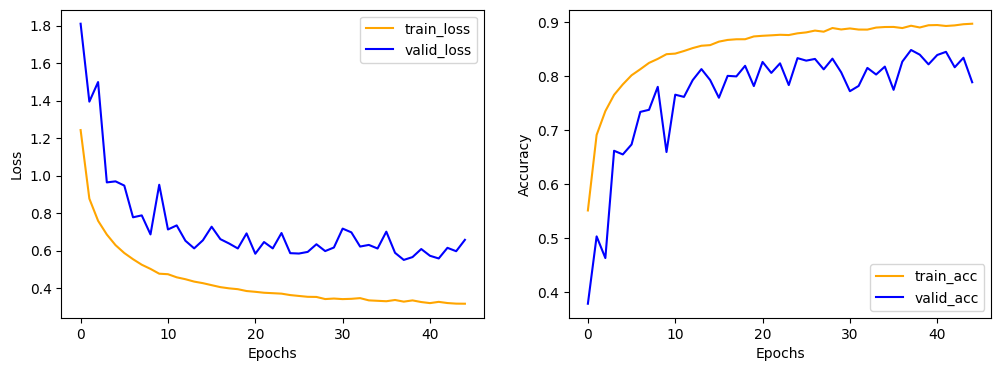

In [52]:
CONFIG = {
    "batchsize": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "epochs": 50
}

device = CONFIG["device"]
epochs = CONFIG["epochs"]
model4 = Model4().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=3e-4, weight_decay=0.009)
# scheduler = ...  # TODO
training_function(model4, loss_fn, optimizer, train_dataset, device, epochs, verbose=True, 
                  validation_strategy='train test split')

In [53]:
curr_time = get_current_time()
curr_time

'29_08_2024__23_40_39'

In [54]:
path = os.path.join(os.getcwd(), curr_time)
os.makedirs(path, exist_ok=True)

print(path)

/kaggle/working/29_08_2024__23_40_39


In [55]:
model_name = "Model4_1.pt"
optimizer_name = "Adam_4.pt"

save_model_info(path, device, model4, model_name, optimizer, optimizer_name)

Model info saved!


In [57]:
path = "/kaggle/working/29_08_2024__23_40_39"
loaded_model2 = Model4().to(device)
loaded_optimizer2 = optim.Adam(params=loaded_model2.parameters(), lr=3e-4, weight_decay=0.0005)
load_model_info(path, device, loaded_model2, model_name, loaded_optimizer2, optimizer_name)

Model info loaded!


In [58]:
def testset_prediction(idx=0):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    loaded_model2.eval()
    loaded_model2.to(device)
    with torch.inference_mode():
        X = test_dataset[idx][0].unsqueeze(dim=0).to(device)
        y = test_dataset[idx][1]
        logit = loaded_model2(X)
        pred_prob = torch.softmax(logit, dim=1)
        pred_label = classes[pred_prob.argmax(dim=1)]
        label_prob = torch.max(pred_prob, dim=1).values.item() * 100
        actual_label = classes[y]
        img = X.squeeze(dim=0).permute(1,2,0).cpu().detach().numpy()
        plt.title(f"Prediction: {pred_label}\nActual: {actual_label}\nPrediction probability: {label_prob:.3f}%")
        plt.imshow(img)
        plt.show()
        
    

testset_prediction(100)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x200704 and 4096x1024)

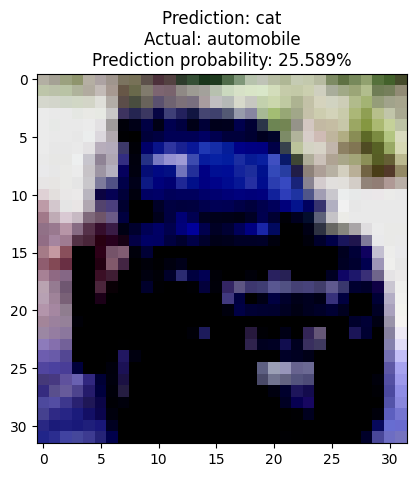

In [95]:
testset_prediction(9)